# Analyse the saliencies for C. Atrox

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

import sys 
sys.path.append('../vespag')

from parse.vep_scores import get_vespag_scores
from src.plotting import *
from src.amino_acid_groups import BIOCHEMICAL_CLASSIFICATION, CHARGE_POLARITY_CLASSIFICATION
from src.constants import GEMME_ALPHABET
from src.utils import *

## Data Loading and Enrichment

Saliencies

In [3]:
saliency_map = np.load('../output_c_atrox/MF974418_1_Crotalus_atrox_saliency.npy')
# Dimension of saliency maps: (sequence length, mutations, embedding dimensions)
print(saliency_map.shape)

(122, 20, 2560)


In [4]:
# load the sequence from the fasta file 
fasta_path = '../data/MF974418_1_Crotalus_atrox.fasta'
with open(fasta_path) as f: 
    fasta = f.readlines()
    sequence = ''.join(fasta[1:]).replace('\n', '')
print(sequence)

SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFVHDCCYGKATDCNPKTVSYTYSEENGEIICGGDDPCGTQICECDKAAAICFRDNIPSYDNKYWLFPPKNCREEPEPC


In [5]:
# check that all elements in the third dimension (=gradients) are zero when the wildtype is equal to the mutant
all_zero = np.all(saliency_map == 0, axis=2)
zero_indices = np.argwhere(all_zero)

not_equal = 0
equal = 0   
for i, j in zero_indices:
    if sequence[i] != GEMME_ALPHABET[j]:
        not_equal += 1
    else:
        equal += 1
print(not_equal, equal)

0 122


VespaG

In [10]:
vespag_path = '/mnt/f/nicole/pla2_vespag/MF974418_1_Crotalus_atrox.csv'
vespag_scores = get_vespag_scores(vespag_path)
vespag_scores.head()

residue mutation    vespag
0      S1      S1A -2.733914
1      S1      S1Y -4.639794
2      S1      S1W -4.962937
3      S1      S1V -4.356812
4      S1      S1T -2.385255

In [11]:
# invert the vespag score to get the mutation effect
vespag_scores['mutation_effect'] = - vespag_scores['vespag']
# extract residue_index 
vespag_scores['residue_index'] = vespag_scores['residue'].str[1:].astype(int)
# extract the wildtype residue
vespag_scores['wildtype'] = vespag_scores['residue'].str[0]
# extract the mutant residue
vespag_scores['mutant'] = vespag_scores['mutation'].str[-1]
# add the amino acid annotations
for classification_name, classification in [('biochemical_class', BIOCHEMICAL_CLASSIFICATION), ('charge_class', CHARGE_POLARITY_CLASSIFICATION)]:
    vespag_scores[f'wildtype_{classification_name}'] = vespag_scores['wildtype'].apply(lambda x: classification[x])
    vespag_scores[f'mutant_{classification_name}'] = vespag_scores['mutant'].apply(lambda x: classification[x])
    vespag_scores[f'change_{classification_name}'] = vespag_scores[f'wildtype_{classification_name}'] != vespag_scores[f'mutant_{classification_name}']
vespag_scores.head()

residue mutation    vespag  mutation_effect  residue_index wildtype mutant  \
0      S1      S1A -2.733914         2.733914              1        S      A   
1      S1      S1Y -4.639794         4.639794              1        S      Y   
2      S1      S1W -4.962937         4.962937              1        S      W   
3      S1      S1V -4.356812         4.356812              1        S      V   
4      S1      S1T -2.385255         2.385255              1        S      T   

  wildtype_biochemical_class mutant_biochemical_class  \
0            polar_uncharged              hydrophobic   
1            polar_uncharged              hydrophobic   
2            polar_uncharged              hydrophobic   
3            polar_uncharged              hydrophobic   
4            polar_uncharged          polar_uncharged   

   change_biochemical_class wildtype_charge_class mutant_charge_class  \
0                      True                 polar           non_polar   
1                      True                 polar               polar   
2                      True                 polar           non_polar   
3                      True                 polar           non_polar   
4                     False                 polar               polar   

   change_charge_class  
0                 True  
1                False  
2                 True  
3                 True  
4                False

In [12]:
# get the average saliency per residue and mutant 
average_saliency = np.mean(saliency_map, axis=2)
# parse this as a dataframe 
average_saliency_df = pd.DataFrame(average_saliency, columns=list(GEMME_ALPHABET))
# add the residue index
average_saliency_df['residue_index'] = np.arange(1, len(sequence)+1)
# tidy the dataframe into a dataframe with these columns: residue_index, mutant, avg_saliency 
average_saliency_df = average_saliency_df.melt(id_vars='residue_index', var_name='mutant', value_name='avg_saliency')
# order by residue index, wildtype
average_saliency_df = average_saliency_df.sort_values(['residue_index', 'mutant'])
average_saliency_df.head()

residue_index mutant  avg_saliency
0                1      A      0.053386
122              1      C      0.051690
244              1      D      0.054496
366              1      E      0.055532
488              1      F      0.064669

In [13]:
# merge the vespag scores with the average saliency
mutation_effect_avg_saliency = average_saliency_df.merge(vespag_scores, on=['residue_index', 'mutant'], how='inner')
mutation_effect_avg_saliency.head()

residue_index mutant  avg_saliency residue mutation    vespag  \
0              1      A      0.053386      S1      S1A -2.733914   
1              1      C      0.051690      S1      S1C -3.132834   
2              1      D      0.054496      S1      S1D -2.926506   
3              1      E      0.055532      S1      S1E -3.226403   
4              1      F      0.064669      S1      S1F -4.838263   

   mutation_effect wildtype wildtype_biochemical_class  \
0         2.733914        S            polar_uncharged   
1         3.132834        S            polar_uncharged   
2         2.926506        S            polar_uncharged   
3         3.226403        S            polar_uncharged   
4         4.838263        S            polar_uncharged   

  mutant_biochemical_class  change_biochemical_class wildtype_charge_class  \
0              hydrophobic                      True                 polar   
1                 cysteine                      True                 polar   
2         negative_charged                      True                 polar   
3         negative_charged                      True                 polar   
4              hydrophobic                      True                 polar   

  mutant_charge_class  change_charge_class  
0           non_polar                 True  
1           non_polar                 True  
2    negative_charged                 True  
3    negative_charged                 True  
4           non_polar                 True

## Mutation Effect vs. Mutant colored by AA Properties

In [15]:
# out of curiosity: look into the saliency for H48 -> H47 due to common numbering scheme
residue_index_one_index = 47
residue_index_zero_index = residue_index_one_index - 1

In [16]:
# saliency_slice = saliency_map[residue_index_zero_index]

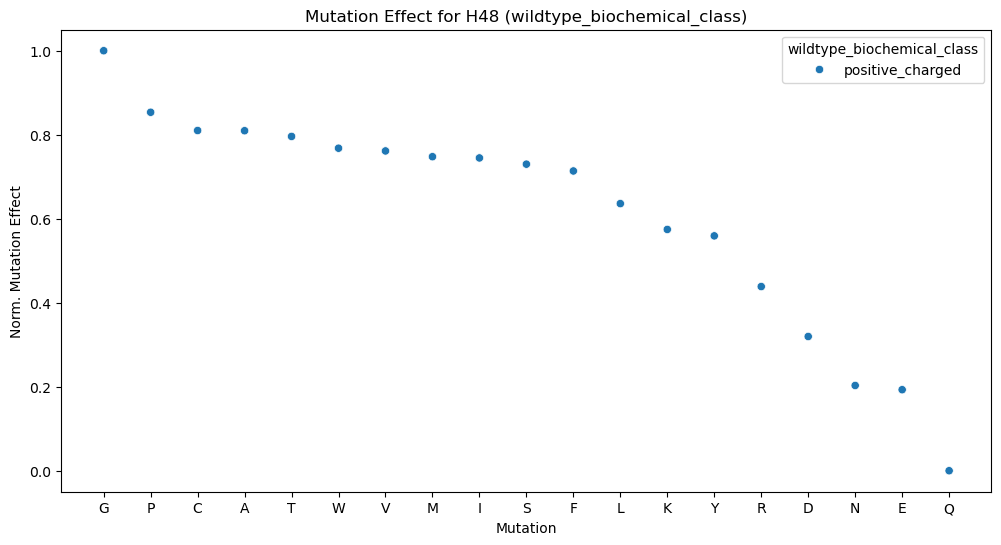

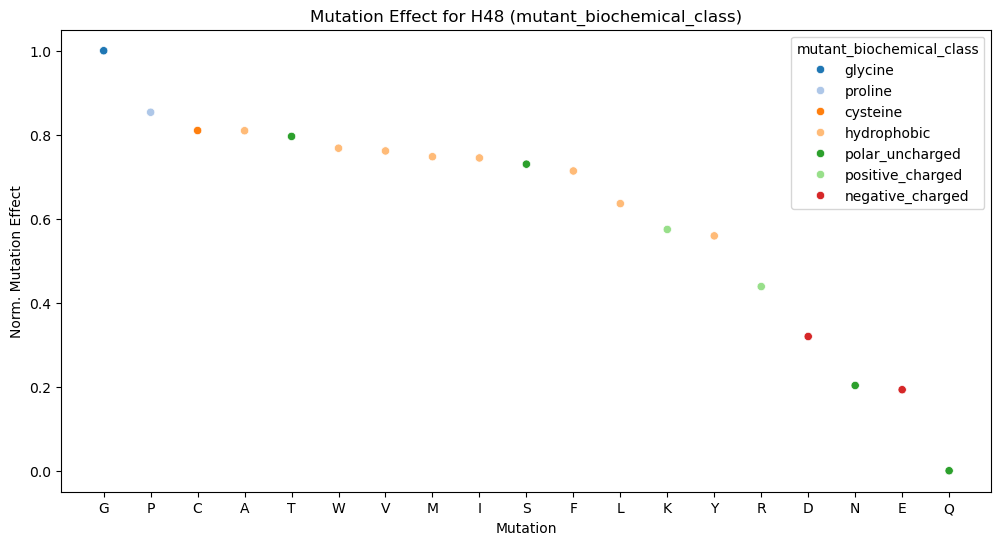

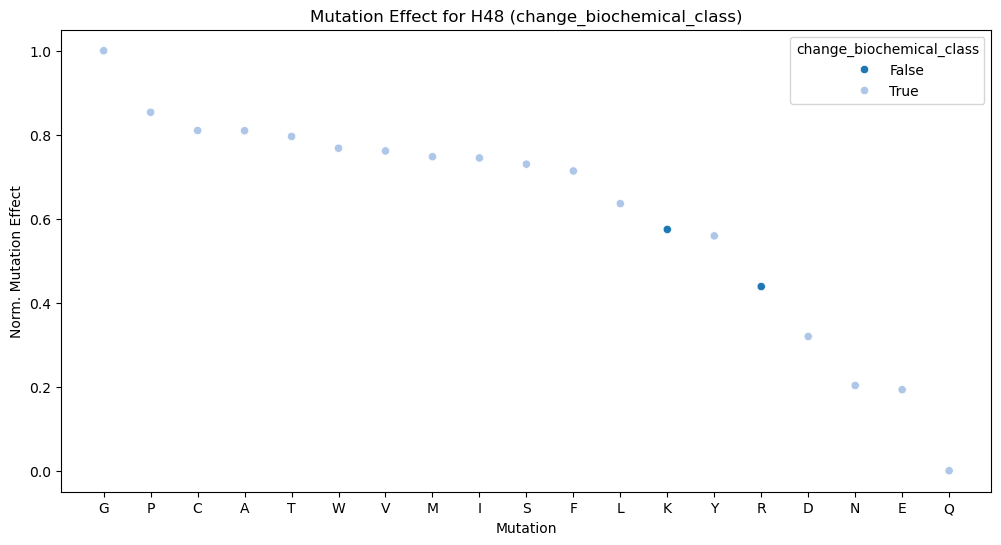

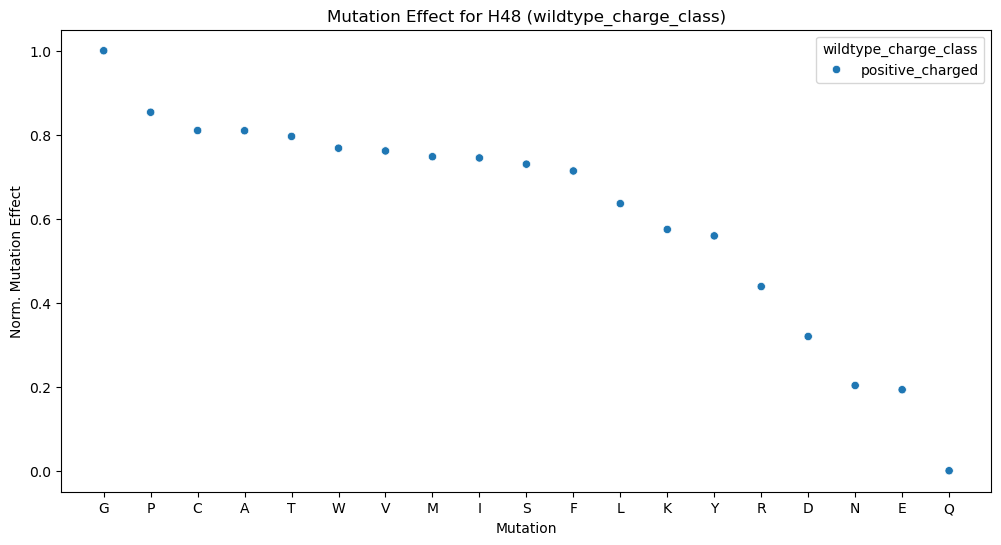

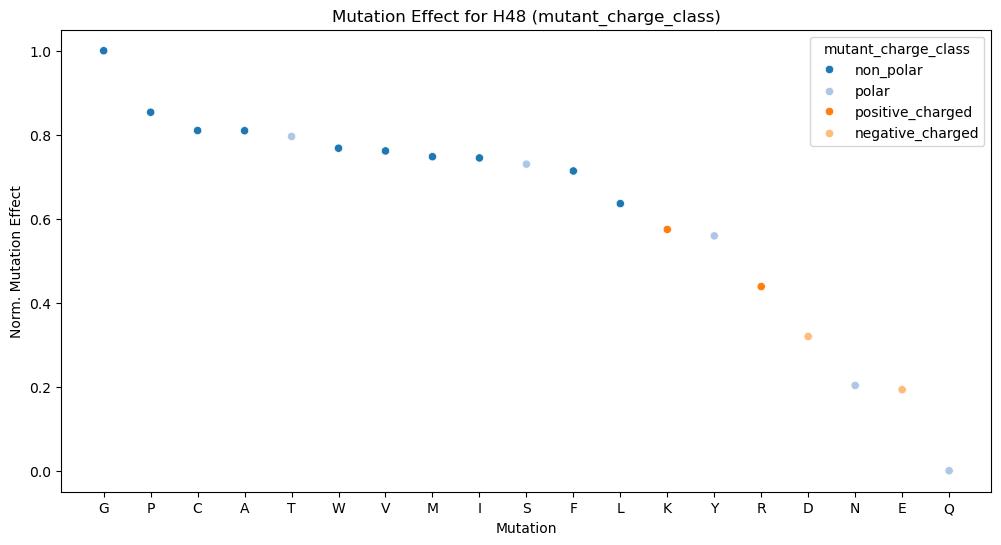

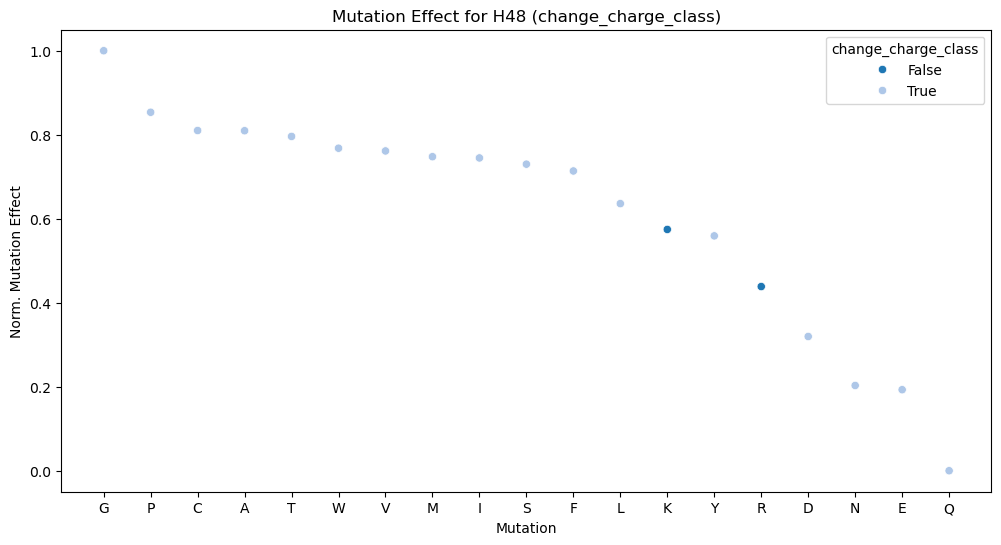

In [21]:
options = ['wildtype_biochemical_class', 'mutant_biochemical_class', 'change_biochemical_class', 'wildtype_charge_class', 'mutant_charge_class', 'change_charge_class']
for option in options:
    plot_mutation_effect_for_residue(mutation_effect_avg_saliency, residue_index_one_index, complexity='simple', title=f"Mutation Effect for H48 ({option})", color_by=option)

## Mutation Effect vs. Saliency colored by AA Properties 

In [22]:
from src.plotting import plot_interactive_mutant_effect_vs_saliency

In [34]:
plot_interactive_mutant_effect_vs_saliency(mutation_effect_avg_saliency, title="Mutation Effect vs Average Saliency")

for option in options:
    plot_interactive_mutant_effect_vs_saliency(mutation_effect_avg_saliency, title=f"Mutation Effect vs Average Saliency ({option})", color_by=option)

## Parallel Coordinates Plot

In [22]:
from src.plotting import plot_parallel_coordinates

In [35]:
mutation_effect_avg_saliency.columns

Index(['residue_index', 'mutant', 'avg_saliency', 'residue', 'mutation',
       'vespag', 'mutation_effect', 'wildtype', 'wildtype_biochemical_class',
       'mutant_biochemical_class', 'change_biochemical_class',
       'wildtype_charge_class', 'mutant_charge_class', 'change_charge_class'],
      dtype='object')

In [39]:
plot_parallel_coordinates(mutation_effect_avg_saliency, columns_to_use=[
    'mutation_effect',
    'avg_saliency',
    'wildtype_biochemical_class',
    'mutant_biochemical_class',
    'wildtype_charge_class',
    'mutant_charge_class',
    'mutant'
    ],
    complexity='simple',
    title="Parallel Coordinates Plot using aa properties of the Mutant"
)
plot_parallel_coordinates(mutation_effect_avg_saliency, columns_to_use=[
    'mutation_effect',
    'avg_saliency',
    'wildtype_biochemical_class',
    'mutant_biochemical_class',
    'wildtype_charge_class',
    'mutant_charge_class',
    'change_biochemical_class',
    'change_charge_class',
    'mutant'
    ],
    complexity='simple',
    title="Parallel Coordinates Plot using aa properties of the Mutant"
)

Label Mapping:
wildtype_biochemical_class: {0: 'cysteine', 1: 'glycine', 2: 'hydrophobic', 3: 'negative_charged', 4: 'polar_uncharged', 5: 'positive_charged', 6: 'proline'}
mutant_biochemical_class: {0: 'cysteine', 1: 'glycine', 2: 'hydrophobic', 3: 'negative_charged', 4: 'polar_uncharged', 5: 'positive_charged', 6: 'proline'}
wildtype_charge_class: {0: 'negative_charged', 1: 'non_polar', 2: 'polar', 3: 'positive_charged'}
mutant_charge_class: {0: 'negative_charged', 1: 'non_polar', 2: 'polar', 3: 'positive_charged'}
mutant: {0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'T', 17: 'V', 18: 'W', 19: 'Y'}


Label Mapping:
wildtype_biochemical_class: {0: 'cysteine', 1: 'glycine', 2: 'hydrophobic', 3: 'negative_charged', 4: 'polar_uncharged', 5: 'positive_charged', 6: 'proline'}
mutant_biochemical_class: {0: 'cysteine', 1: 'glycine', 2: 'hydrophobic', 3: 'negative_charged', 4: 'polar_uncharged', 5: 'positive_charged', 6: 'proline'}
wildtype_charge_class: {0: 'negative_charged', 1: 'non_polar', 2: 'polar', 3: 'positive_charged'}
mutant_charge_class: {0: 'negative_charged', 1: 'non_polar', 2: 'polar', 3: 'positive_charged'}
change_biochemical_class: {0: False, 1: True}
change_charge_class: {0: False, 1: True}
mutant: {0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'T', 17: 'V', 18: 'W', 19: 'Y'}


## Boxplots and Violinplots

In [40]:
mutation_effect_avg_saliency[['mutation_effect', 'wildtype']].groupby('wildtype')

In [43]:
mutation_effect_avg_saliency.columns

Index(['residue_index', 'mutant', 'avg_saliency', 'residue', 'mutation',
       'vespag', 'mutation_effect', 'wildtype', 'wildtype_biochemical_class',
       'mutant_biochemical_class', 'change_biochemical_class',
       'wildtype_charge_class', 'mutant_charge_class', 'change_charge_class'],
      dtype='object')

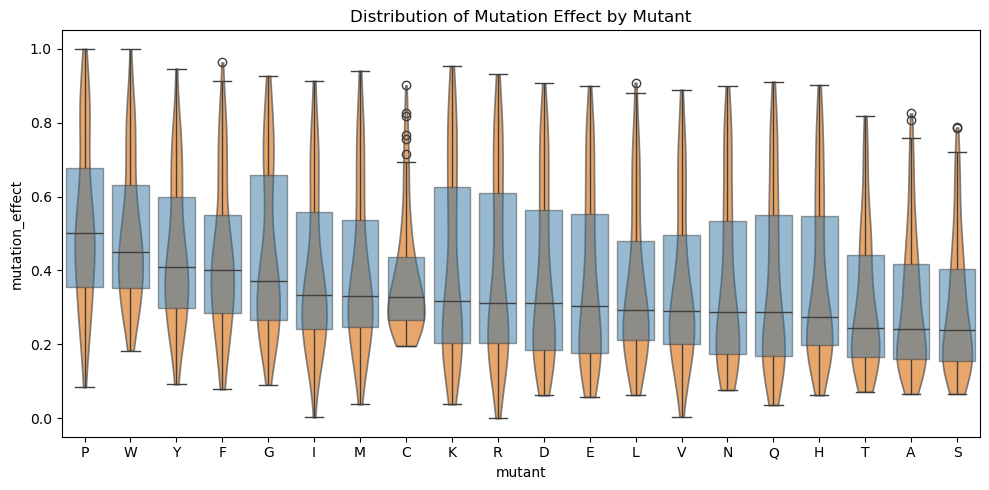

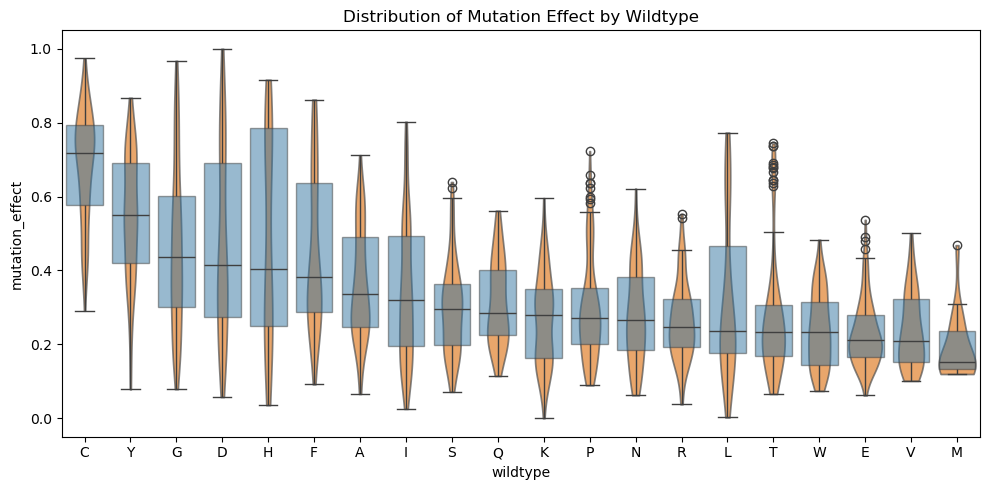

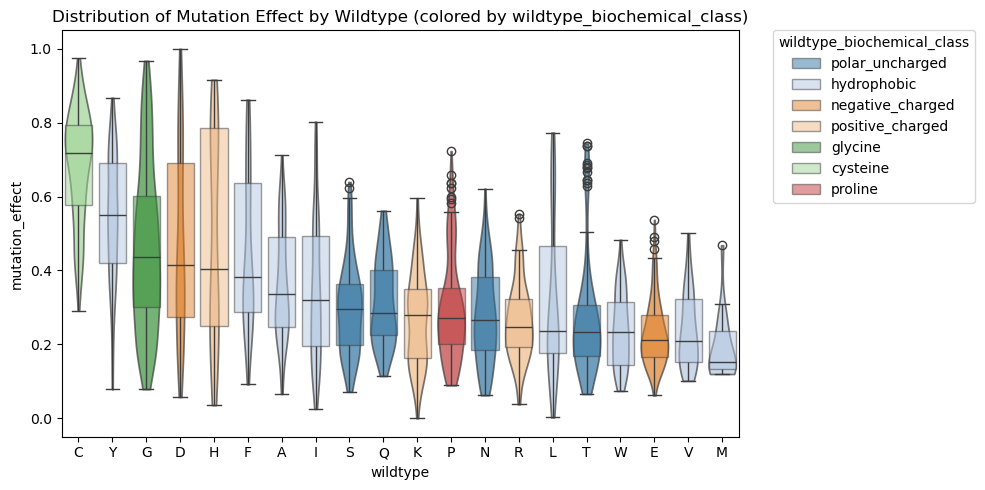

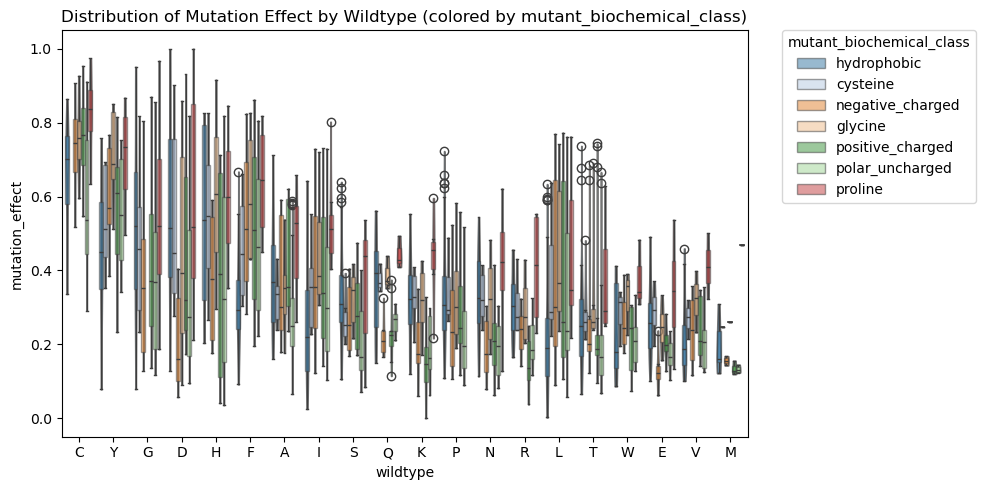

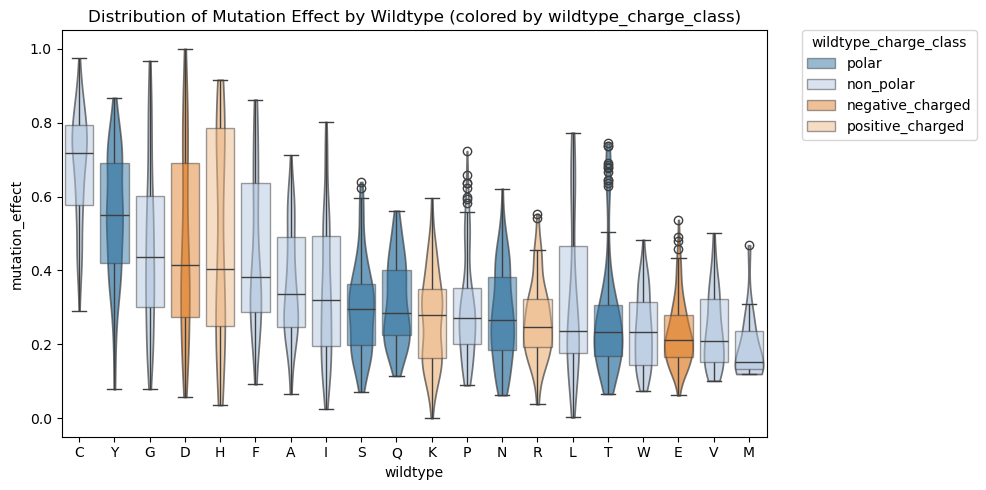

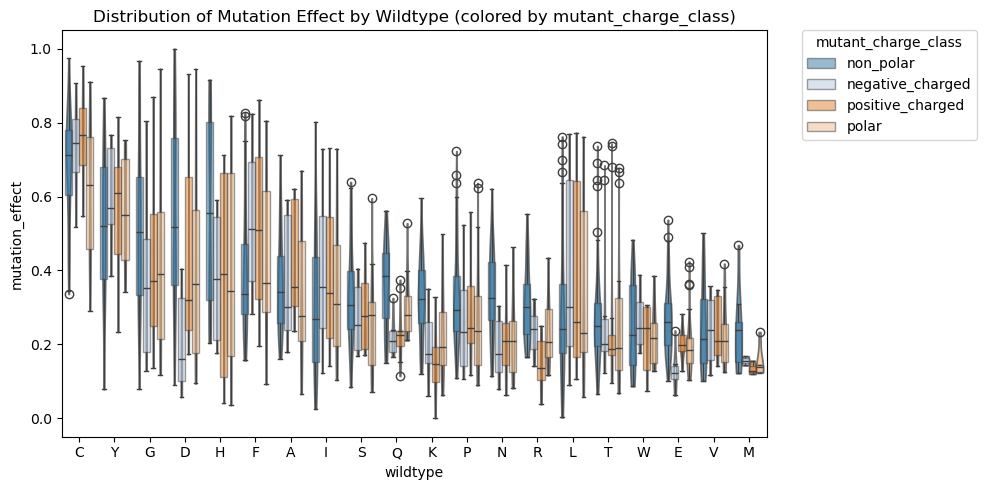

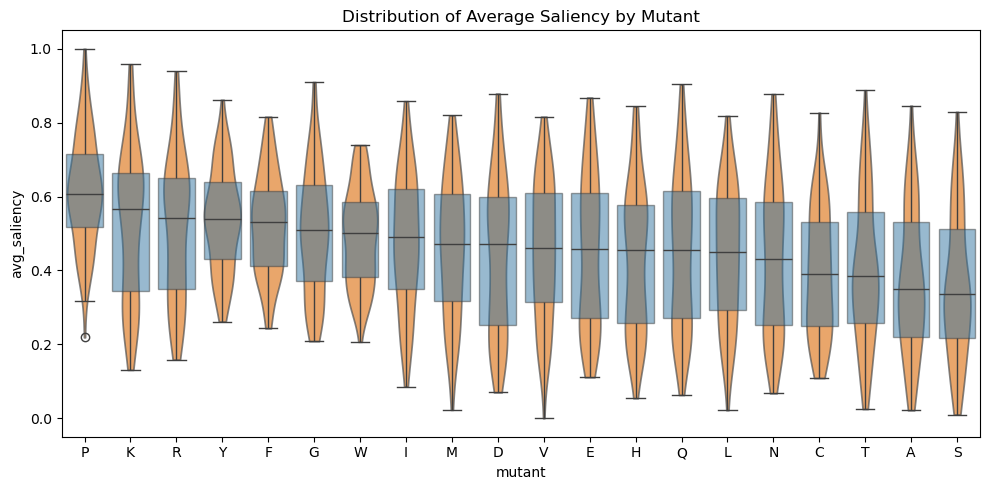

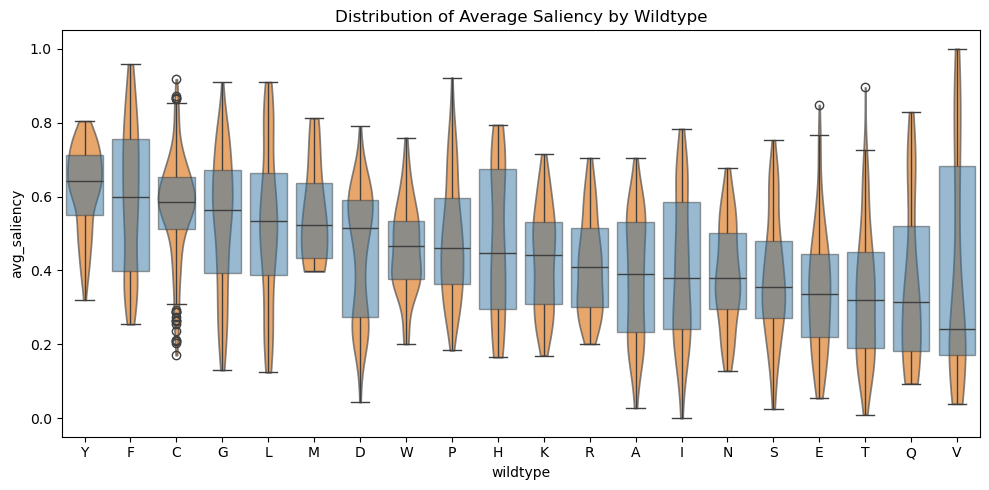

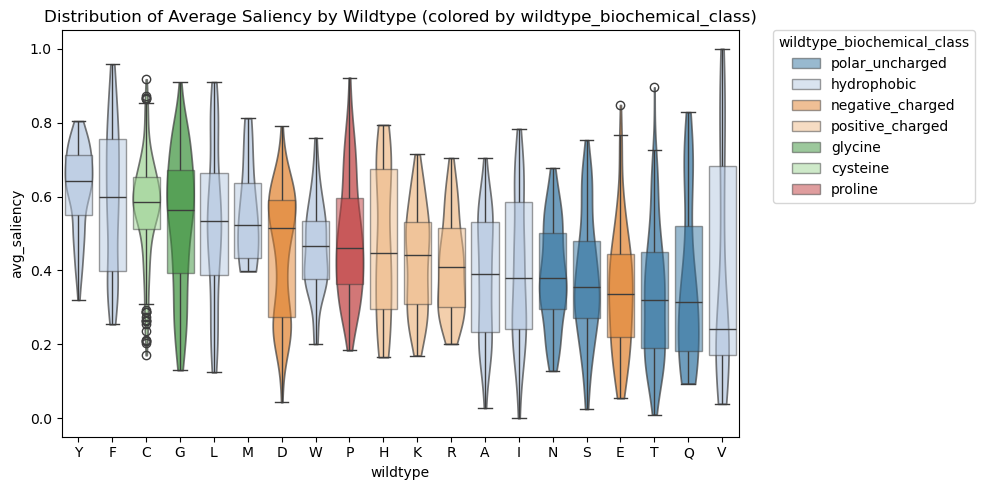

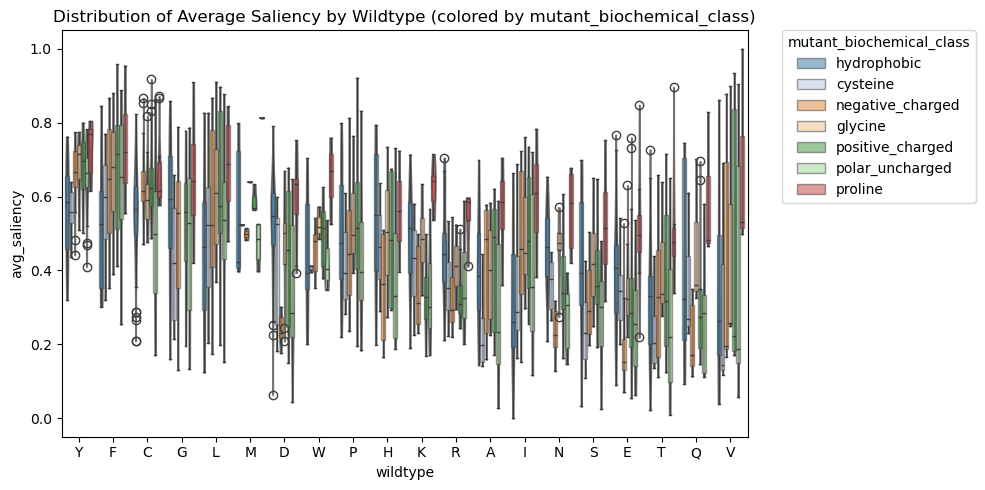

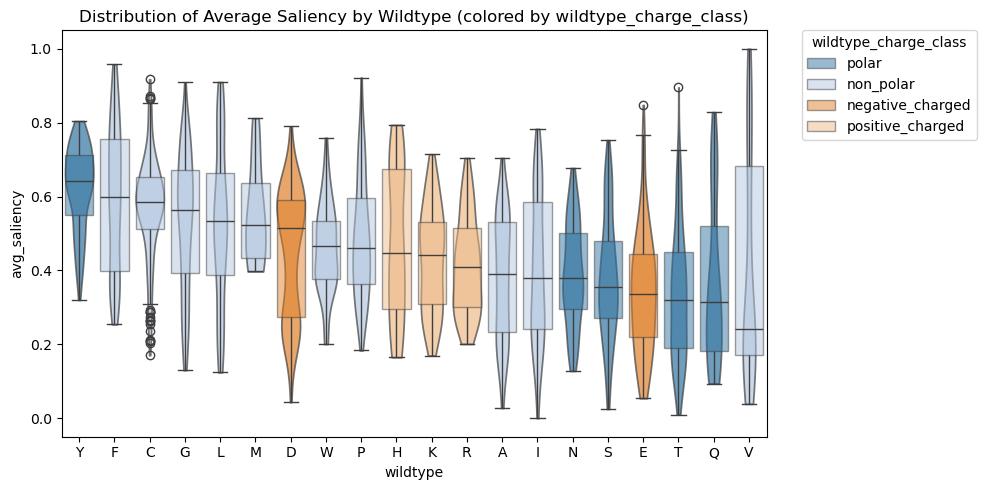

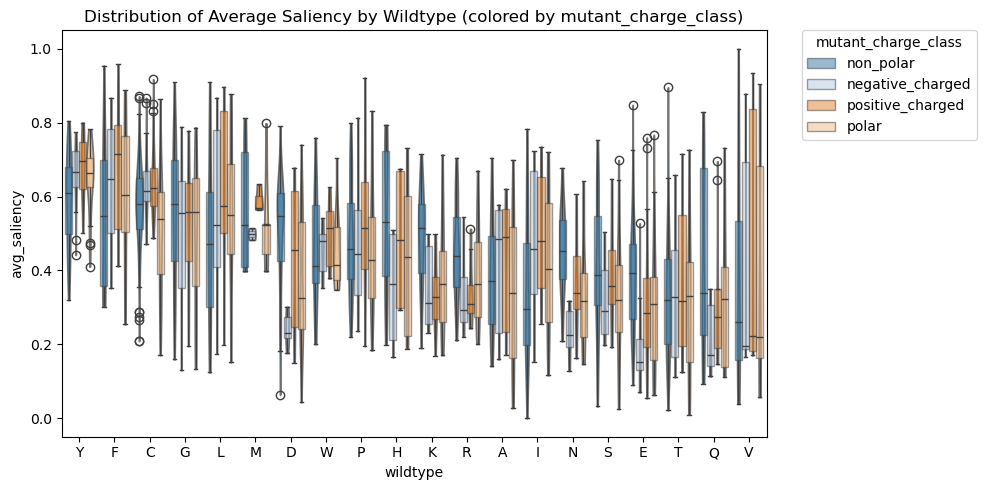

In [44]:
# mutation effect
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='mutant', title="Distribution of Mutation Effect by Mutant")
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype")
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype (colored by wildtype_biochemical_class)", color_by='wildtype_biochemical_class')
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype (colored by mutant_biochemical_class)", color_by='mutant_biochemical_class')
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype (colored by wildtype_charge_class)", color_by='wildtype_charge_class')
plot_distribution(mutation_effect_avg_saliency, data_column='mutation_effect', label_column='wildtype', title="Distribution of Mutation Effect by Wildtype (colored by mutant_charge_class)", color_by='mutant_charge_class')

# saliency 
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='mutant', title="Distribution of Average Saliency by Mutant")
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype")
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype (colored by wildtype_biochemical_class)", color_by='wildtype_biochemical_class')
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype (colored by mutant_biochemical_class)", color_by='mutant_biochemical_class')
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype (colored by wildtype_charge_class)", color_by='wildtype_charge_class')
plot_distribution(mutation_effect_avg_saliency, data_column='avg_saliency', label_column='wildtype', title="Distribution of Average Saliency by Wildtype (colored by mutant_charge_class)", color_by='mutant_charge_class')
